In [1]:
# Classic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
import os
from sklearn.model_selection import train_test_split

# libaries
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import Model, Sequential
from keras.applications import MobileNetV2, VGG19, VGG16

In [2]:
# load dataset from kaggle

# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d gpiosenka/100-bird-species
# ! unzip 100-bird-species.zip -d birds

In [3]:
class CONFIG():
  # files & directories
  MAIN_PATH = './birds'
  CHECKPOINT = 'models'
  CSV_FILE = 'birds.csv'
  # variables
  IMAGE_SIZE = (224, 224)
  INPUT_SHAPE = (*IMAGE_SIZE, 3)
  NUM_CLASSES = 500
  BATCH_SIZE = 128
  EPOCHS = 10

In [4]:
dataset = pd.read_csv(os.path.join(CONFIG.MAIN_PATH, CONFIG.CSV_FILE))
dataset = dataset[dataset['class id'].map(lambda x: x in range(CONFIG.NUM_CLASSES))]
dataset['filepaths'] = dataset['filepaths'].map(lambda x: os.path.join(CONFIG.MAIN_PATH, x))
dataset

,class id,filepaths,labels,data set,scientific name
0,0,./birds/train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
1,0,./birds/train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
2,0,./birds/train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
3,0,./birds/train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
4,0,./birds/train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train,Malacocincla abbotti
...,...,...,...,...,...
85080,499,./birds/valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid,Xanthocephalus
85081,499,./birds/valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid,Xanthocephalus
85082,499,./birds/valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid,Xanthocephalus
85083,499,./birds/valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid,Xanthocephalus


In [5]:
# get train, test and valid sets
df_trainset = dataset[dataset['data set'] == 'train'][['class id', 'filepaths', 'labels']]
df_validset = dataset[dataset['data set'] == 'valid'][['class id', 'filepaths', 'labels']]
df_testset = dataset[dataset['data set'] == 'test'][['class id', 'filepaths', 'labels']]

# print shapes
print('Trainset shape:', df_trainset.shape)
print('Validset shape:', df_validset.shape)
print('Testset shape:', df_testset.shape)

Trainset shape: (80085, 3)
Validset shape: (2500, 3)
Testset shape: (2500, 3)


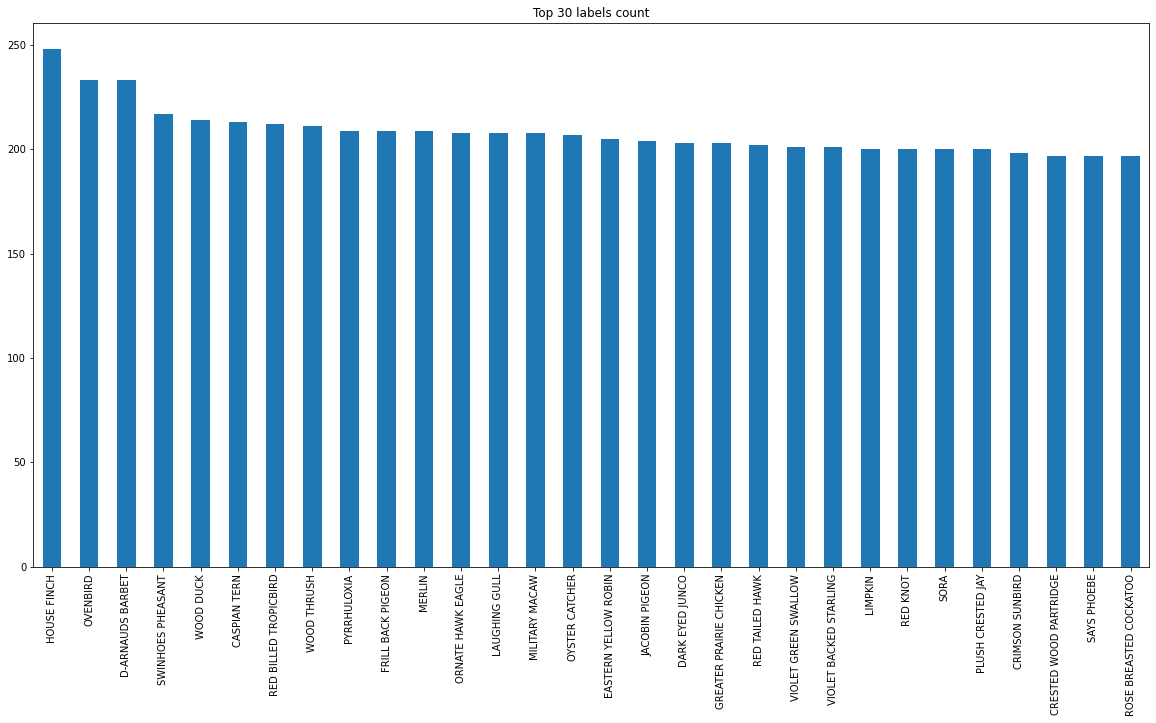

In [6]:
df_trainset['labels'].value_counts()[:30].plot(kind='bar', figsize=(20,10), title='Top 30 labels count')
plt.show()

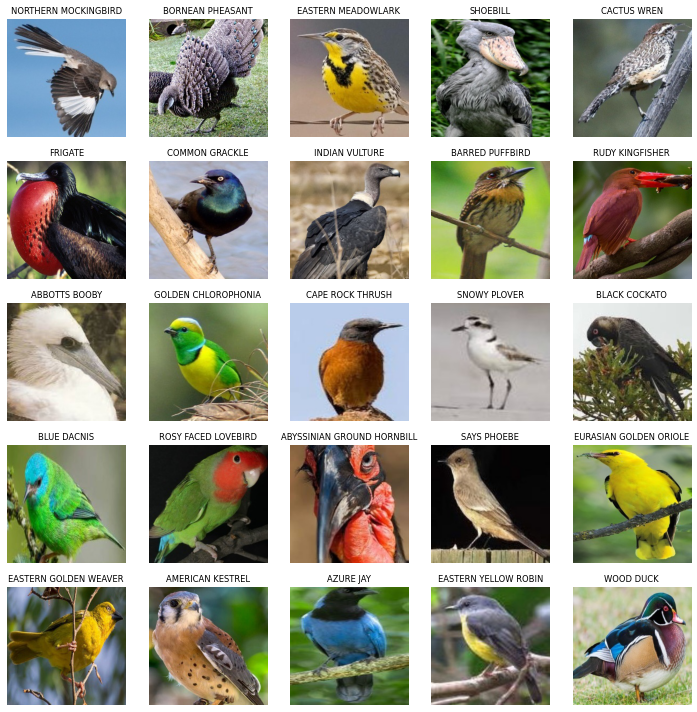

In [7]:
random_index = np.random.randint(0, len(df_trainset), 25)
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_trainset.filepaths[random_index[i]]))
    ax.set_title(df_trainset.labels[random_index[i]], fontsize='small')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,          # randomly rotate images by up to 20 degrees
    width_shift_range=0.1,      # randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,     # randomly shift images vertically by up to 10% of the height
    zoom_range=0.2,             # randomly zoom in on images by up to 20%
    horizontal_flip=True,       # randomly flip images horizontally
    fill_mode='nearest',        # fill any empty pixels with the nearest available pixel
)

test_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [9]:
# Split the data into three categories
train_images = train_image_generator.flow_from_dataframe(
    dataframe=df_trainset,
    x_col='filepaths',
    y_col='labels',
    batch_size=CONFIG.BATCH_SIZE,
    target_size=CONFIG.IMAGE_SIZE,
    featurewise_std_normalization=True,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=1,
    subset='training'
)

valid_images = train_image_generator.flow_from_dataframe(
    dataframe=df_validset,
    x_col='filepaths',
    y_col='labels',
    batch_size=CONFIG.BATCH_SIZE,
    target_size=CONFIG.IMAGE_SIZE,
    featurewise_std_normalization=True,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=1,
    subset='training'
)

test_images = test_image_generator.flow_from_dataframe(
    dataframe=df_testset,
    x_col='filepaths',
    y_col='labels',
    batch_size=len(df_testset),
    target_size=CONFIG.IMAGE_SIZE,
    featurewise_std_normalization=True,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=1,
    subset='training'
)

Found 80085 validated image filenames belonging to 500 classes.
Found 2500 validated image filenames belonging to 500 classes.
Found 2500 validated image filenames belonging to 500 classes.


In [10]:
base_model = VGG16(
    input_shape=CONFIG.INPUT_SHAPE, 
    include_top=False, 
    weights='imagenet', 
    pooling='avg'
)

base_model.trainable=False

In [11]:
for layer in base_model.layers[-5:]:
  layer.trainable = True

In [12]:
for layer in base_model.layers:
  print(layer.trainable, layer)

False <keras.engine.input_layer.InputLayer object at 0x7f4f31a59220>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fb0fb80>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f30068490>
False <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f4f30093cd0>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fc70160>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f300e98e0>
False <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f4f2ffff280>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fc7d100>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fc7db80>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fc7d130>
False <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f4f2fc81dc0>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fc8f310>
False <keras.layers.convolutional.conv2d.Conv2D object at 0x7f4f2fc8fdc0>
False <keras.layers.co

In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(*CONFIG.IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
inputs = base_model.input
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CONFIG.NUM_CLASSES, activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# ! pip install tensorflow_addons
import tensorflow_addons as tfa

stop = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.05, mode='min')
checkpoint = ModelCheckpoint(filepath=os.path.join(CONFIG.MAIN_PATH, CONFIG.CHECKPOINT, 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'), monitor='val_loss', verbose=True, save_best_only=True, mode='min')
callbacks = [checkpoint, stop]

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-3),
    tf.keras.optimizers.Adam(learning_rate=1.5e-4)
]

optimizers_and_layers = [
    (optimizers[0], model.layers[-5:]), 
    (optimizers[1], model.layers[-10:-5])
]

optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, validation_data=valid_images, epochs=CONFIG.EPOCHS, callbacks=callbacks)

Epoch 1/10
480/626 [======================>.......] - ETA: 3:33 - loss: 4.0591 - accuracy: 0.1665

In [ ]:
results = model.evaluate(test_images)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)

In [ ]:
from keras.models import load_model

# Load the model
best_model = load_model(os.path.join(CONFIG.MAIN_PATH, CONFIG.CHECKPOINT, 'my_best_model.epoch05-loss0.45.hdf5'))

In [ ]:
test_images[0][0].shape

In [ ]:
preds = best_model.predict(test_images[0][0])

In [ ]:
np.mean(preds.argmax(axis=1) == test_images[0][1].argmax(axis=1))